In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import corner

import nestle
import dynesty as dn
import emcee
from dynesty import plotting as dyplot

## EGG BOX - multimodal

To test the performance of samplers, we'll use the eggbox model demonstrated in the nestle examples, using bilby to choose different samplers.

In [21]:
tmax = 5.0 * np.pi
constant = np.log(1.0 / tmax**2)

def loglike(x):
    t = 2.0 * tmax * x - tmax
#     u = 2.0 * tmax * y - tmax
    return (2.0 + np.cos(t[0]/2.0)*np.cos(t[1]/2.0))**5.0

def prior(x):
    return x

Text(0.5, 1.0, 'True Log likelihood surface')

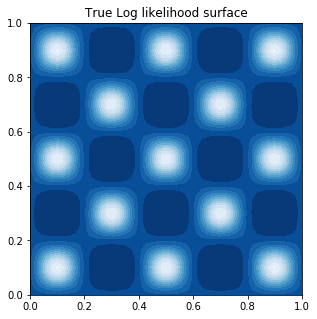

In [22]:
plt.figure(figsize=(5., 5.))
ax = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 50),
                     np.linspace(0., 1., 50))
Z = loglike(np.array([xx, yy]))
ax.contourf(xx, yy, Z, 12, cmap=plt.cm.Blues_r)
plt.title("True Log likelihood surface")

## nestle

niter: 1539
ncall: 2999
nsamples: 1739
logz: 236.167 +/-  0.171
h:  5.821


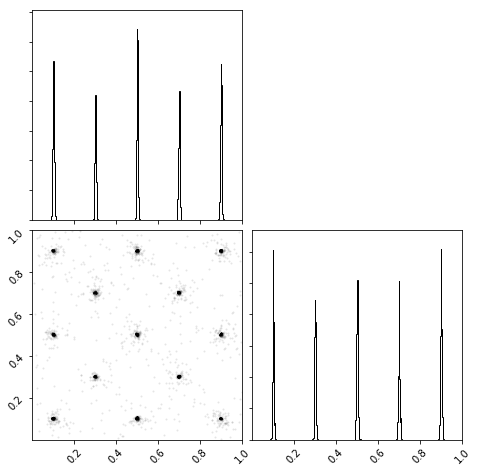

In [23]:
res = nestle.sample(loglike, prior, 2, npoints=200, method='multi',
                    update_interval=20)
print(res.summary())
fig = corner.corner(res.samples, weights=res.weights, bins=500,
                    range=[(0., 1.), (0., 1.)])
fig.set_size_inches(8., 8.)

In bilby, we need to build our own likelihood class to run the sampler on:

## dynesty

In [24]:
import dynesty as dn

In [25]:
# sampling on the unit cube so our samples are already normalized on (0,1)
def ptform(u):
    return u

In [26]:
# "Static" nested sampling.
ndim = 2

sampler = dn.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

# "Dynamic" nested sampling.
dsampler = dn.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results

iter: 19087 | batch: 10 | bound: 52 | nc: 4 | ncall: 51546 | eff(%): 37.029 | loglstar: 236.346 < 243.000 < 242.737 | logz: 236.092 +/-  0.154 | stop:  0.927                                         


In [ ]:
cfig, caxes = dyplot.cornerplot(sresults)
cdfig, cdaxes = dyplot.cornerplot(dresults)

### emcee

In [ ]:
import emcee

In [ ]:
ndim, nwalkers = 2, 1000
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike)
sampler.run_mcmc(p0, 10000)

samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples)

### pymc3

## bilby

# MINIMIZERS example - bimodal

In [18]:
def f2min(x):
    return -(x[0]**2-1)*(x[1]**2-1)*np.cos(4*np.pi*x[0])*np.cos(2*np.pi*x[1])

def ptform_f2(u):
    return 2. * u - 1

niter: 3316
ncall: 9384
nsamples: 5316
logz:  0.031 +/-  0.004
h:  0.035


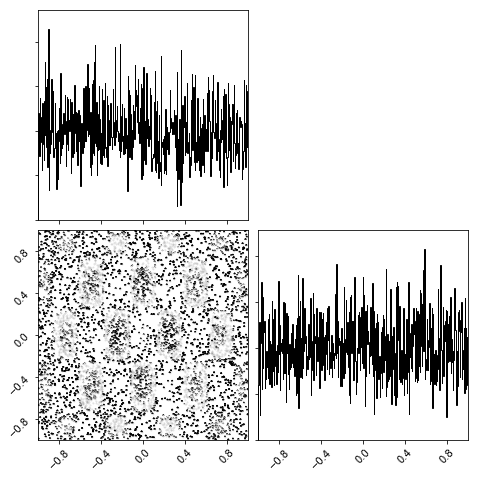

In [19]:
res = nestle.sample(f2min, ptform_f2, 2, npoints=2000, method='multi',
                    update_interval=20)
print(res.summary())
fig = corner.corner(res.samples, weights=res.weights, bins=500,
                    range=[(-1., 1.), (-1., 1.)])
fig.set_size_inches(8., 8.)

In [17]:
# "Static" nested sampling.
ndim = 2

sampler = dn.NestedSampler(f2min, ptform_f2, ndim)
sampler.run_nested()
sresults = sampler.results

# "Dynamic" nested sampling.
dsampler = dn.DynamicNestedSampler(f2min, ptform_f2, ndim)
dsampler.run_nested()
dresults = dsampler.results

iter: 13586 | batch: 14 | bound: 0 | nc: 1 | ncall: 32439 | eff(%): 41.882 | loglstar:   -inf <  0.997 <  0.010 | logz:  0.034 +/-  0.042 | stop:  1.232                                              

KeyboardInterrupt: 

In [ ]:
cfig, caxes = dyplot.cornerplot(sresults)
cdfig, cdaxes = dyplot.cornerplot(dresults)

In [ ]:
ndim, nwalkers = 2, 1000
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler_e = emcee.EnsembleSampler(nwalkers, ndim, loglike)
sampler_e.run_mcmc(p0, 10000)

samples = sampler_e.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples)

## Conclusion

(Current) conclusion: nested sampling will ALWAYS do well, but will take long (especially with more expensive and complex models). emcee isn't good for multimodal distributions (see fitting a model for more emcee applications). Also, pymc3 and bilby are a pain to use and will take longer for us to become comfortable enough with them to include here. People with more experience with either are welcome to contribute to this notebook!